# Statistics

Generate statistics from the `csv` file.

In [10]:
import csv
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.pyplot import figure

In [11]:

with open('../openssl_files/results_distinct.csv', mode='r') as csv_file:
    csv_reader = csv.DictReader(csv_file)
    dict_list = []
    for row in csv_reader:
        dict_list.append(row)



In [28]:
ranges = [0,0.05,0.1,0.15,0.2,0.25,0.3]

def range_per_dict(input_dict):
    counter = [0] * len(ranges)
    for output in input_dict:
        
        placed = [False,False] # Tuples are immutable
        for i in range(1,len(ranges)):
            last_i = i-1
            if float(output["incoming time"]) >= ranges[last_i] and float(output["incoming time"]) < ranges[i]:
                counter[last_i] = counter[last_i] + 1
                placed[0] = True
            if float(output["outgoing time"]) >= ranges[last_i] and float(output["outgoing time"]) < ranges[i]:
                counter[last_i] = counter[last_i] + 1
                placed[1] = True
                
        if placed[0] == False:
            counter[len(ranges)-1] = counter[len(ranges)-1] + 1
        if placed[1] == False:
            counter[len(ranges)-1] = counter[len(ranges)-1] + 1
            
    return counter



filter_z3 = list(filter(lambda a : a["SMT solver"] == "z3", dict_list))
range_z3 = range_per_dict(filter_z3)
filter_yices = list(filter(lambda a : a["SMT solver"] == "yices", dict_list))
range_yices = range_per_dict(filter_yices)
filter_msat = list(filter(lambda a : a["SMT solver"] == "msat", dict_list))
range_msat = range_per_dict(filter_msat)
filter_cvc4 = list(filter(lambda a : a["SMT solver"] == "cvc4", dict_list))
range_cvc4 = range_per_dict(filter_cvc4)        



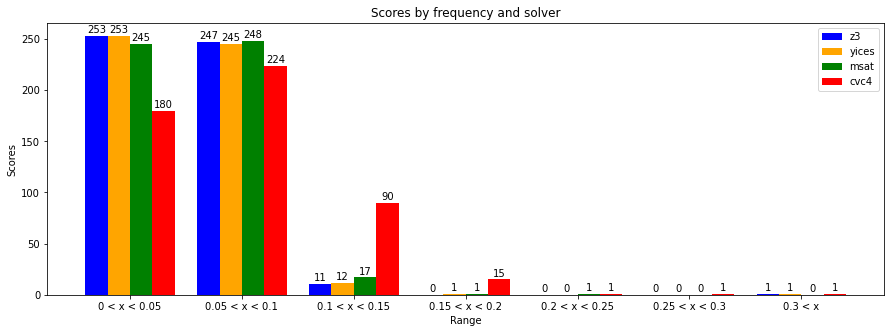

In [55]:
labels = []
for i in range(1, len(ranges)):
    labels.append(str(ranges[i-1]) + " < x < " + str(ranges[i]))
labels.append(str(ranges[len(ranges)-1]) + " < x")
x = np.arange(len(ranges)) 

width = 0.2  



fig, ax = plt.subplots()
rects1 = ax.bar(x - 1.5*width, range_z3, width, color='blue', label='z3')
rects2 = ax.bar(x - 0.5*width, range_yices, width, color='orange', label='yices')
rects3 = ax.bar(x + 0.5*width, range_msat, width, color='green', label='msat')
rects4 = ax.bar(x + 1.5*width, range_cvc4, width, color='red', label='cvc4')
fig.set_size_inches(15,5)


ax.set_ylabel('Scores')
ax.set_xlabel('Range')
ax.set_title('Scores by frequency and solver')
ax.set_xticks(x, labels)
ax.legend()

ax.bar_label(rects1, padding=1)
ax.bar_label(rects2, padding=1)
ax.bar_label(rects3, padding=1)
ax.bar_label(rects4, padding=1)



plt.show()

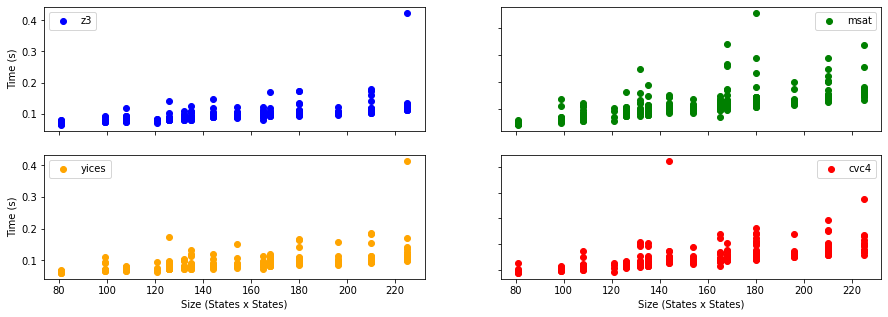

In [56]:
def exection_time_vs_size(solver_list):
    x_size = []
    y_time = []
    for row in solver_list:
        x_size.append(float(row["reference model: number of states"]) * float(row["updated model: number of states"]))
        y_time.append(float(row["incoming time"]) + float(row["outgoing time"]))
    return (x_size,y_time)



plot_exection_z3 = exection_time_vs_size(filter_z3)
plot_exection_yices = exection_time_vs_size(filter_yices)
plot_exection_msat = exection_time_vs_size(filter_msat)
plot_exection_cvc4 = exection_time_vs_size(filter_cvc4)

fig, axs = plt.subplots(2, 2)
fig.set_size_inches(15,5)

axs[0,0].plot(plot_exection_z3[0], plot_exection_z3[1], 'o', color='blue', label='z3');

axs[1,0].plot(plot_exection_yices[0], plot_exection_yices[1], 'o', color='orange', label='yices');

axs[0,1].plot(plot_exection_msat[0], plot_exection_msat[1], 'o', color='green', label='msat');

axs[1,1].plot(plot_exection_cvc4[0], plot_exection_cvc4[1], 'o', color='red', label='cvc4');

for ax in axs.flat:
    ax.set(xlabel='Size (States x States)', ylabel='Time (s)')
    ax.legend()
    ax.label_outer()
    
    
plt.show()
    

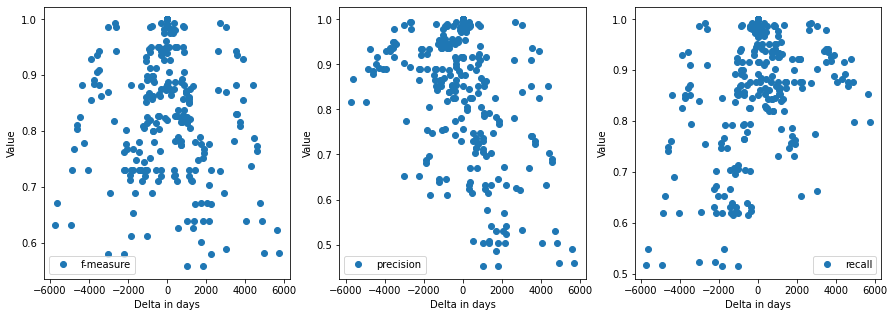

In [63]:
x_delta_time = []
y_f_measure = []
y_precision = []
y_recall = [] 
for row in filter_z3:
    x_delta_time.append(int(row["delta date (days)"]))
    y_f_measure.append(float(row["f-measure"]))
    y_precision.append(float(row["precision"]))
    y_recall.append(float(row["recall"]))
    
fig, axs = plt.subplots(1, 3)
fig.set_size_inches(15,5)

axs[0].plot(x_delta_time, y_f_measure,"o" , label='f-measure');
axs[1].plot(x_delta_time, y_precision,"o" , label='precision');
axs[2].plot(x_delta_time, y_recall,"o" , label='recall');

for ax in axs.flat:
    ax.set(xlabel='Delta in days', ylabel='Value')
    ax.legend()

plt.show()